In [ ]:
import os
from os import path
from imutils import paths

#numbers
import math
import random

#data
import numpy as np
import scipy.io as scio
from scipy.signal import convolve2d
import pandas as pd

#imgs
import cv2
from PIL import Image, ImageOps, ImageEnhance

#graph
import matplotlib.pyplot as plt


#tensorflow
import tensorflow as tf
from tensorflow import keras

#sickit learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

#import keras
from keras.utils import np_utils, plot_model
from keras.layers import Dense
from keras.models import Sequential

#Pytorch
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F

#own file
#import utils
#import vizualizers
#import normalizers
from autoaugment import CIFAR10Policy, SubPolicy
from pretty_confusion_matrix import pp_matrix_from_data, pp_matrix

In [ ]:
def txError(X, X2):
  sum = 0
  X, X2 = np.array(X, dtype='int'), np.array(X2, dtype='int')
  for i in range(len(X)):
    isF = False
    for j in range(len(X[i])):
      if X[i][j] != X2[i][j]:
        isF = True
    if isF:
      sum += 1
  return sum/len(X)

In [ ]:
def affiche_classe(x,clas,K,w, title):
    plt.title(title)
    t=[np.min(x[:,0]),np.max(x[:,0])]
    z=[(-w[0]-w[1]*np.min(x[:,0]))/w[2],(-w[0]-w[1]*np.max(x[:,0]))/w[2]]
   
    plt.plot(t,z);
    
    ind=(clas==1)
    plt.plot(x[ind,0],x[ind,1],"o")
    
    ind=(clas==2)
    plt.plot(x[ind,0],x[ind,1],"x")
    plt.axis([np.min(x[:,0]),np.max(x[:,0]),np.min(x[:,1]),np.max(x[:,1])])
    plt.show()

1. Développement d'un perceptron

1.1 Mise en place d'un perceptron

In [ ]:
def perceptron_simple(x, w, active):
  sum = np.sum(np.multiply(np.array([1,x[0],x[1]]),w))
  if active == True:
    y = np.sign(sum)
  elif active == False:
    y = np.tanh(sum)
  return y

Result avec 0,0 : -1.0
Result avec 0,1 : 1.0
Result avec 1,0 : 1.0
Result avec 1,1 : 1.0


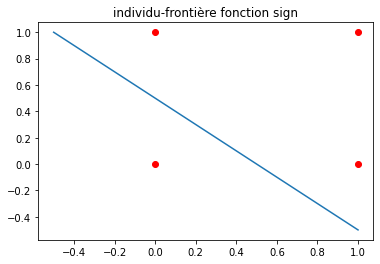

In [ ]:
p = np.array([[0,0],[0,1],[1,0],[1,1]])
w = np.array([-0.5, 1,1])
print("Result avec 0,0 :" , perceptron_simple(p[0], w, True))
print("Result avec 0,1 :" , perceptron_simple(p[1], w, True))
print("Result avec 1,0 :" , perceptron_simple(p[2], w, True))
print("Result avec 1,1 :" , perceptron_simple(p[3], w, True))

plt.plot([-0.5,1],[1 ,-0.5])
plt.plot([0, 0, 1, 1], [0, 1, 0, 1], 'ro')
plt.title('individu-frontière fonction sign')
plt.savefig("individu-frontière fonctionsign.png")
plt.show()

1.2 Etude de l'apprentissage
1.2.1 Widrow-hoff

In [ ]:
def apprentissage_widrow(X, yd, epoch, batch_size):
  #init weight as 2 random values between 0 and 1
  w = np.random.rand(3)
  listWeights = [w]
  listErrors = np.zeros(epochs)
  E = 0
  for i in range(epoch):
    weightj = w
    for j in range(len(X)):
      #calculate the y and de la dérivé de y
      y = perceptron_simple(X[j], w, False)

      #mise a jour de r
      r = - (yd[j] - y) * (1 - y * y)

      #calcul du poids
      weightj[1] = weightj[1] - 0.1 * r * X[j][0]
      weightj[2] = weightj[2] - 0.1 * r * X[j][1]
     
      #calcul de l'erreur
      E += -(yd[j] - y)**2

      #change weight, reset Error if batch size is reached
      if j % batch_size == 0:
        w = weightj
        listWeights.append(w.copy())
        affiche_classe(X, yd, 3, w, E)
    listErrors[i] = E
  return w, listWeights, listErrors

1.2.2 Test simple

(50, 2)


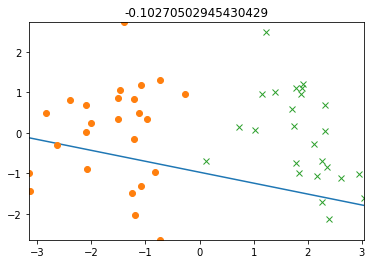

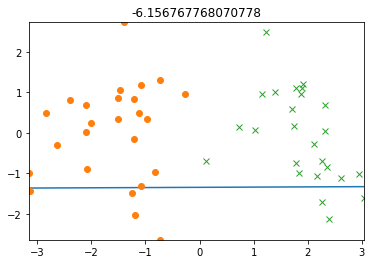

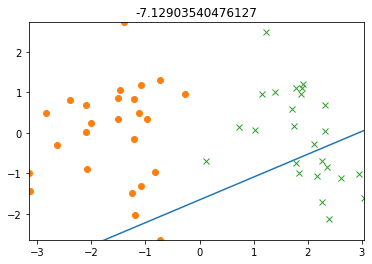

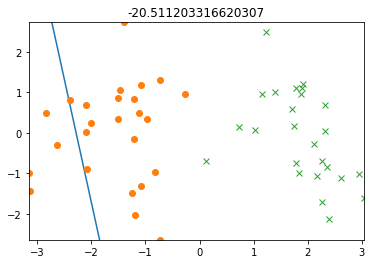

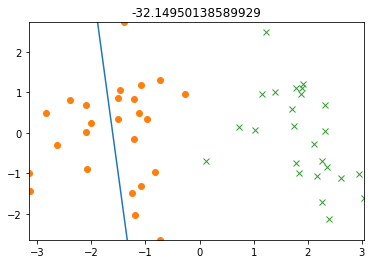

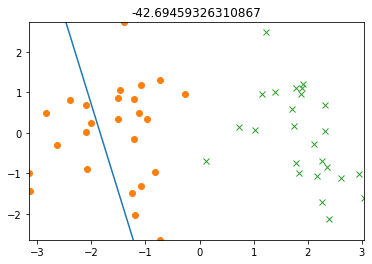

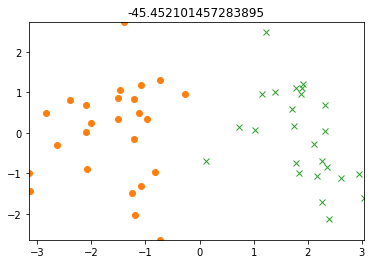

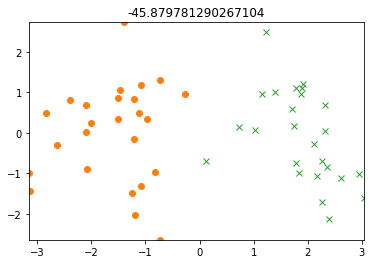

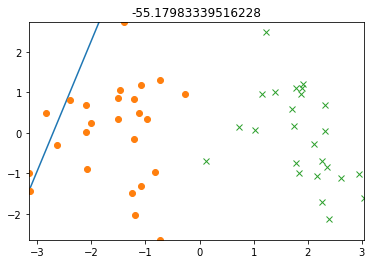

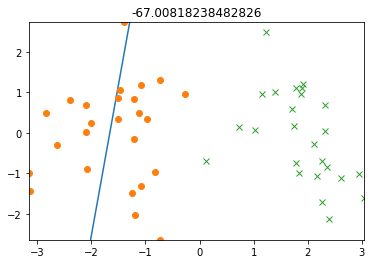

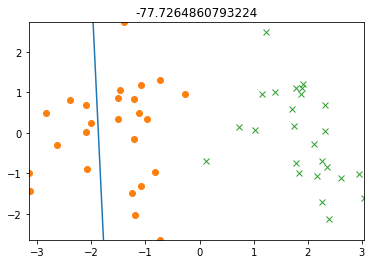

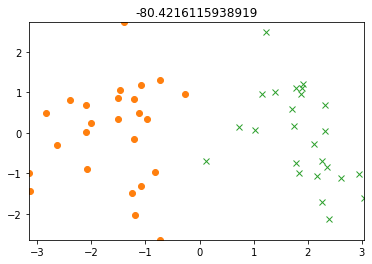

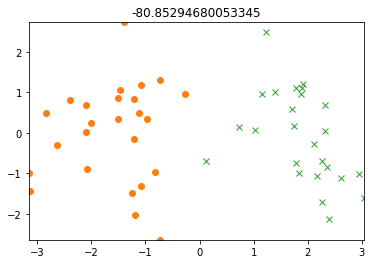

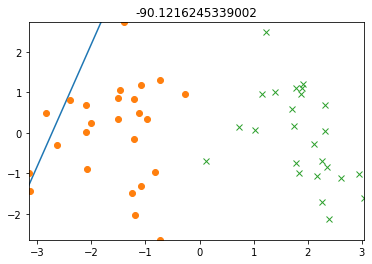

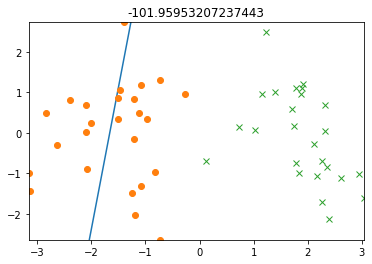

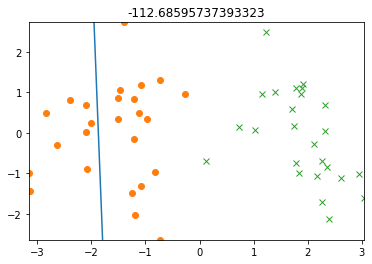

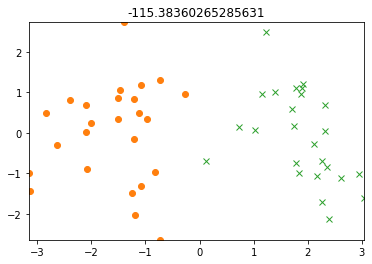

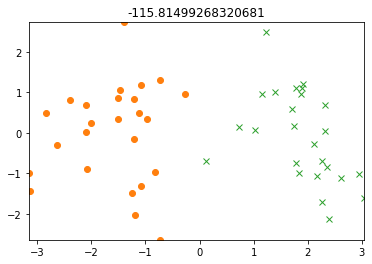

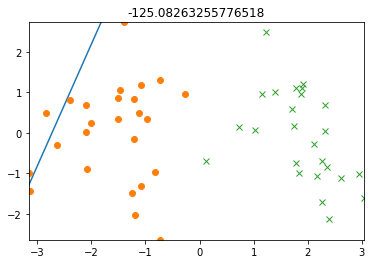

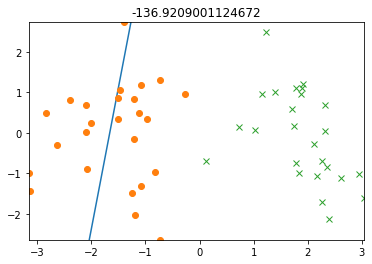

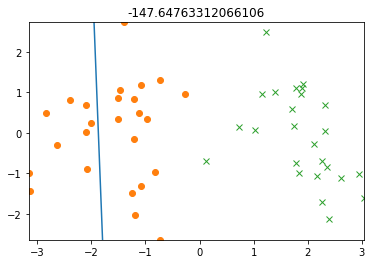

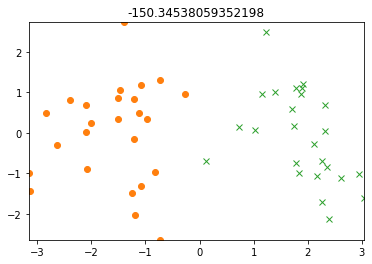

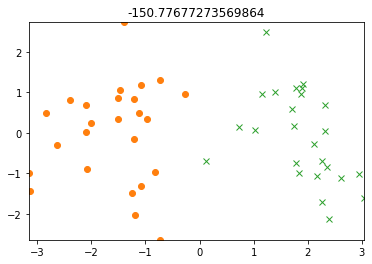

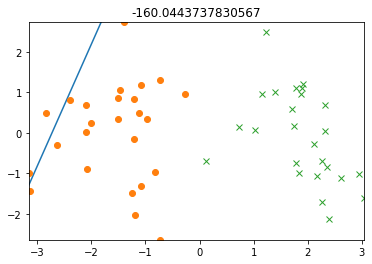

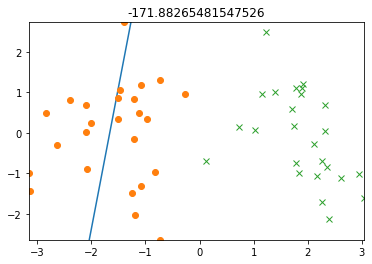

W== [ 0.9210226   0.65430859 -0.02352135]
Errors== [ -41.59482599  -76.56927586 -111.52579049 -146.48735315 -181.44911514]


In [ ]:
Data = np.loadtxt('p2_d1.txt')
Data = np.flipud(np.rot90(Data))
classeData = np.ones(50)
classeData[25:50] += 1
epochs = 5
print(Data.shape)
w, listWeights, error = apprentissage_widrow(Data, classeData, epochs, 10)
print("W==", w)
print("Errors==", error)

1.2.3 Test 2

(50, 2)


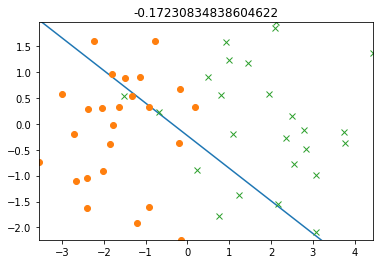

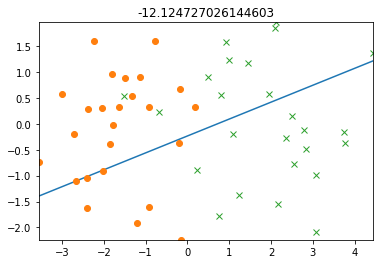

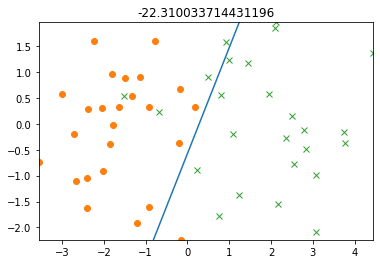

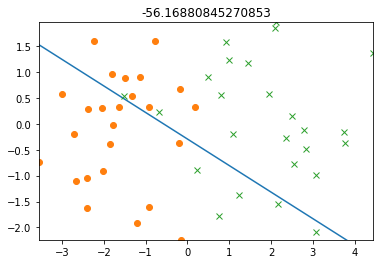

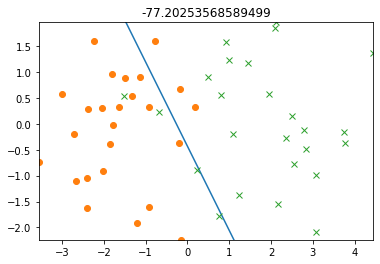

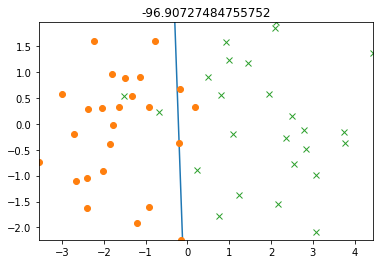

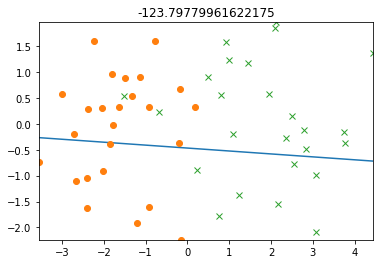

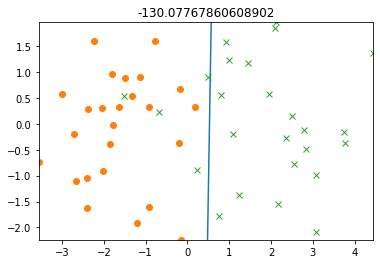

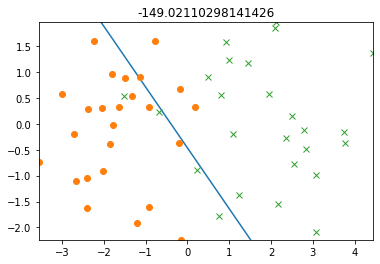

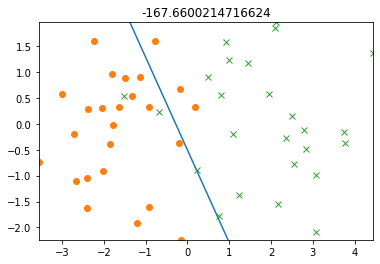

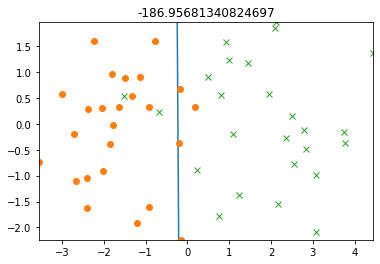

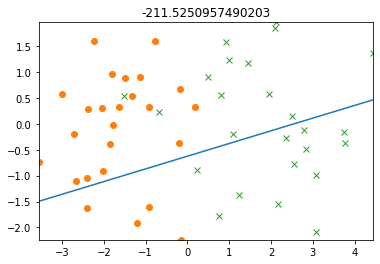

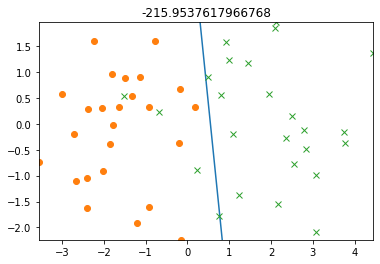

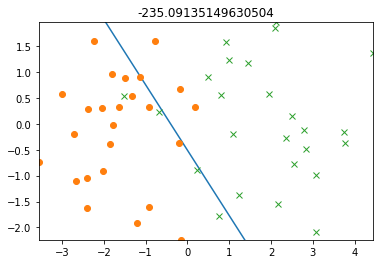

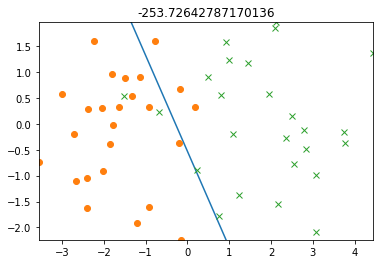

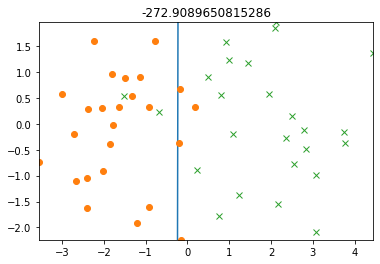

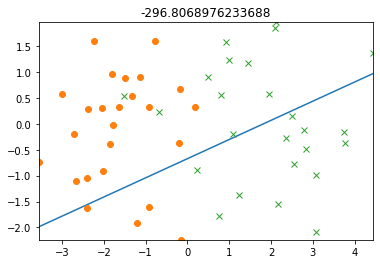

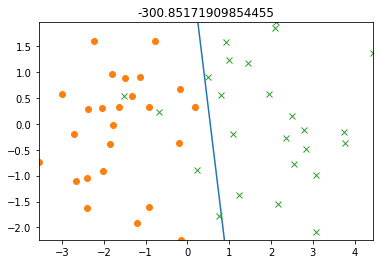

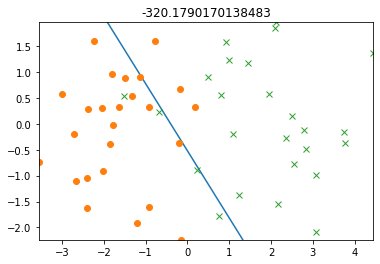

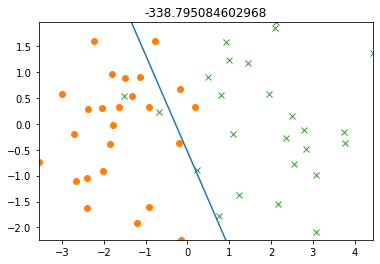

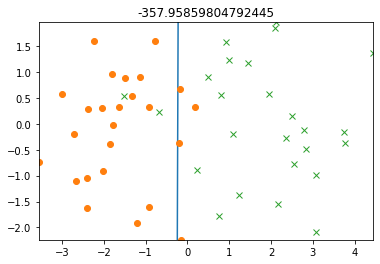

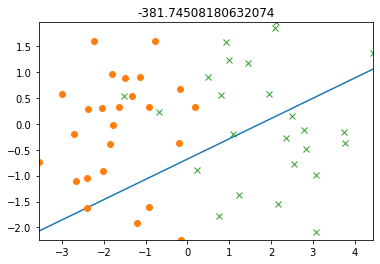

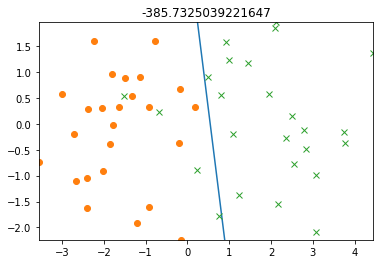

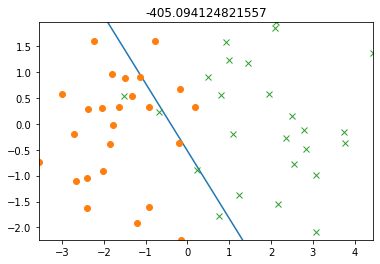

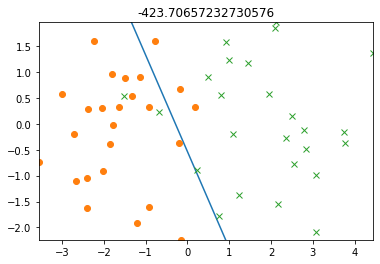

W== [ 0.22999943  0.97409204 -0.02203074]
R== [ -96.55952773 -186.58555827 -272.53080528 -357.5792787  -442.4875289 ]


In [ ]:
Data = np.loadtxt('p2_d2.txt')
Data = np.flipud(np.rot90(Data))
classeData = np.ones(50)
classeData[25:50] += 1
epochs = 5
print(Data.shape)
w, listWeights, error = apprentissage_widrow(Data, classeData, epochs, 10)
print("W==", w)
print("R==", error)

1.3 Pereptron multicouches

1.3.1 Mise en place d'un perceptron multicouche

In [ ]:
#Forward propagation
def multiperceptron(x, w1, w2):
  #calculate j1,j2 and F(j1), F(j2) of hidden layer
  j = np.zeros(len(w1))
  Fj = np.zeros(len(w1))
  for i in range(len(j)): #for each neuron on hidden layer
    for z in range(len(x)): #compute with each x in entrance
      j[i] += w1[i][z] * x[z]
    j[i] += w1[i][0] #add b
    Fj[i] = (1/(1+math.exp(-j[i]))) #activation function

  #calculate output
  y = 0
  for i in range(len(Fj)): #compute with neuron on hidden layer
    y += Fj[i] * w2[i]
  y += w2[0]

  return Fj, (1/(1+math.exp(-y)))

In [ ]:
#test multiperceptron
x = np.array([1,1])
w1 = np.array([[-0.5, 2,-1], [0.5, 1, 0.5]])
w2 = np.array([2, -1, 1])
print("Output obtain with x[1,1] = ", multiperceptron(x,w1,w2))

Output obtain with x[1,1] =  (array([0.73105858, 0.88079708]), 0.9296496528262661)


1.3.2 Programmation apprentissage multicouches

In [ ]:
def multiperceptron_widrow(x, yd, Epoch, Batch_size, alpha):
  #set random weights for w1 and w2
  w1 = np.random.rand(2, 3)
  w2 = np.random.rand(3)
  listW = [w1, w2]
  listE = [0]
  for i in range(Epoch):
    w2C = w2.copy()
    w1C = w1.copy()
    E = 0
    for j in range(len(x)):
      #calculate the output y
      y1, y = multiperceptron(x[j], w1, w2)

      #get errors of boths w1 and w2 as : r11, r12 and r2
      r2 = - (yd[j] - y) * (y - y * y)
      r11 = w2[1] * r2 * (y1[0] - y1[0] * y1[0])
      r12 = w2[2] * r2 * (y1[1] - y1[1] * y1[1])

      #get new weights for w1 and w2 as : w11, w12 and w2
      w2C[1] = w2[1] - alpha * r2 * y1[1]
      w2C[2] = w2[2] - alpha * r2 * y1[1]
      w1C[0][1] = w1[0][1] - alpha * r11 * x[j][0]
      w1C[0][2] = w1[0][2] - alpha * r11 * x[j][1]
      w1C[1][1] =  w1[1][1] - alpha * r12 * x[j][0]
      w1C[1][2] =  w1[1][2] - alpha * r12 * x[j][1]
     
      #change cumulate error
      E += -(yd[j] - y)**2

      #change weight, reset Error if batch size is reached
      if j % Batch_size == 0:
        w2 = w2C
        w1 = w1C
        listW.append([w1, w2])
        listE.append(E)

  return w1,w2,E,listW,listE

In [ ]:
#test XOR on multiperceptron
x = np.array([[1,0,0],[1,1,0],[1,0,1],[1,1,1]])
yd = np.array([0,1,1,0])
w1,w2,E,listW,listE = multiperceptron_widrow(x, yd, 10, 10, 0.5)
print("W2 =", w2)
print("W1 =", w1)
print("Result avec 0,0 :" , multiperceptron(x[0], w1, w2))
print("Result avec 0,1 :" , multiperceptron(x[1], w1, w2))
print("Result avec 1,0 :" , multiperceptron(x[2], w1, w2))
print("Result avec 1,1 :" , multiperceptron(x[3], w1, w2))

W2 = [ 0.19250984 -0.09740677 -0.00036764]
W1 = [[0.59580903 0.15829175 0.79266601]
 [0.27041717 0.34810963 0.59776811]]
Result avec 0,0 : (array([0.76703033, 0.63200649]), 0.5692051719703036)
Result avec 0,1 : (array([0.79411488, 0.7086722 ]), 0.5686524508318512)
Result avec 1,0 : (array([0.87913711, 0.75742296]), 0.5715001254646561)
Result avec 1,1 : (array([0.89497297, 0.81558426]), 0.5708591973092876)


In [ ]:
#test multiperceptron widrow
Data = np.loadtxt('p2_d1.txt')
Data = np.flipud(np.rot90(Data))
classeData = np.ones(50)
classeData[25:50] += 1
epochs = 50
w1,w2,E,listW,listE = multiperceptron_widrow(Data, classeData, epochs, 10)
print("W==", w1)
print("W==", w2)
print("R==", E)
print("listW==", listW)
print("listE==", listE)

2. Deep et Full-connected : discrimination d'une image

2.1 Calcul des descripteurs

In [ ]:
def wang(measure_name):
  print("Preparing datas with the measure : ", measure_name)
  #import one of the 5 measures
  if measure_name == 'PHOG':
    measure = pd.read_excel('WangSignatures.xlsx', sheet_name='WangSignaturesPHOG',index_col=0,header=None)
  elif measure_name == 'JCD':
    measure = pd.read_excel('WangSignatures.xlsx', sheet_name='WangSignaturesJCD',index_col=0, header=None)
  elif measure_name == 'CEDD':
    measure = pd.read_excel('WangSignatures.xlsx', sheet_name='WangSignaturesCEDD',index_col=0, header=None)
  elif measure_name == 'FCTH':
    measure = pd.read_excel('WangSignatures.xlsx', sheet_name='WangSignaturesFCTH',index_col=0, header=None)
  elif measure_name == 'FCH':
    measure = pd.read_excel('WangSignatures.xlsx', sheet_name='WangSignaturesFuzzyColorHistogr',index_col=0, header=None)

  #set up vector of name, label for the images
  print("Set up X and Y and return them")
  X = []
  y = np.zeros([1000,10], 'int')
  
  for j,measure_name in enumerate(measure.index):
    #get the name of the image thanks to the id of the column which is the name of the image
    index = int( os.path.splitext(measure_name)[0])
    if index < 100:
      X.append(measure.iloc[j].to_numpy())
      y[j][0] = 1
    elif index < 200:
      X.append(measure.iloc[j].to_numpy())
      y[j][1] = 1
    elif index < 300:
      X.append(measure.iloc[j].to_numpy())
      y[j][2] = 1
    elif index < 400:
      X.append(measure.iloc[j].to_numpy())
      y[j][3] = 1
    elif index < 500:
      X.append(measure.iloc[j].to_numpy())
      y[j][4] = 1
    elif index < 600:
      X.append(measure.iloc[j].to_numpy())
      y[j][5] = 1
    elif index < 700:
      X.append(measure.iloc[j].to_numpy())
      y[j][6] = 1
    elif index < 800:
      X.append(measure.iloc[j].to_numpy())
      y[j][7] = 1
    elif index < 900:
      X.append(measure.iloc[j].to_numpy())
      y[j][8] = 1
    elif index < 1000:
      X.append(measure.iloc[j].to_numpy())
      y[j][9] = 1
  X = np.array(X)
  return X,y #train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [ ]:
#concatenate all the datas
X,y = wang('PHOG')
Mesure = X
Label_P = y

X,y = wang('JCD') 
Mesure = np.concatenate((Mesure, X), axis=1)

X,y = wang('CEDD') 
Mesure = np.concatenate((Mesure, X), axis=1)

X,y = wang('FCTH') 
Mesure = np.concatenate((Mesure, X), axis=1)

X,y = wang('FCH') 
Mesure = np.concatenate((Mesure, X), axis=1)

print(Mesure.shape)
print(Label_P.shape)

Preparing datas with the measure :  PHOG
Set up X and Y and return them
Preparing datas with the measure :  JCD
Set up X and Y and return them
Preparing datas with the measure :  CEDD
Set up X and Y and return them
Preparing datas with the measure :  FCTH
Set up X and Y and return them
Preparing datas with the measure :  FCH
Set up X and Y and return them
(1000, 884)
(1000, 10)


2.2 Mise en place d'un système de discrimination basée structure Full-Connected

In [ ]:
def getGraphLoss(history, name, Loss):
  # Get training and test loss histories
  training_loss = history.history['loss']
  test_loss = history.history['val_loss']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Training Loss', 'Test Loss'])
  plt.title(name)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.text(20., 3., 'Loss : ' + str(Loss))
  plt.savefig(name + ".png")
  plt.show()
def getGraphAccuracy(history, name, Acc):
  # Get training and test loss histories
  training_loss = history.history['accuracy']
  test_loss = history.history['val_accuracy']

  # Create count of the number of epochs
  epoch_count = range(1, len(training_loss) + 1)

  # Visualize loss history
  plt.plot(epoch_count, training_loss, 'r--')
  plt.plot(epoch_count, test_loss, 'b-')
  plt.legend(['Training Accuracy', 'Test Accuracy'])
  plt.title(name)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  numb = round(Acc, 4) * 100
  plt.text(10., 0.3, 'Accuracy mean : ' + str(numb))
  plt.savefig(name + ".png")
  plt.show()

In [ ]:
# configuration variables
# -----------------------------------------------------------------
batch_size = 175
n_classes = 10
epochs = 50

#X_train, X_test, Y_train, Y_test = wang('PHOG')
X_train, X_test, Y_train, Y_test = train_test_split(Mesure, Label_P, test_size=0.2, random_state=1, stratify=Label_P)

# neural network
model = keras.Sequential()

# layer 1
model.add(keras.layers.Dense(256, activation='relu', name="Layer_1"))

# First Batch Normalisation
model.add(keras.layers.BatchNormalization())

# layer 2
model.add(keras.layers.Dense(128, activation='relu', name="Layer_2"))


# First Batch Normalisation
model.add(keras.layers.BatchNormalization())

# layer 3
model.add(keras.layers.Dense(64, activation='relu', name="Layer_3"))


# First Batch Normalisation
model.add(keras.layers.BatchNormalization())

# layer 4
model.add(keras.layers.Dense(32, activation='relu', name="Layer_4"))


# First Batch Normalisation
model.add(keras.layers.BatchNormalization())

#Output layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_classes, name="Output", activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, validation_data=(X_test, Y_test)) 
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=1)
model.summary()
getGraphLoss(history, "Loss evolution epoch==50 with batch size == " + str(175), test_loss)
getGraphAccuracy(history, "Accuracy evolution epoch==50 with batch size == " + str(175), test_acc)
print("Value of loss: ", test_loss, " Value of accuracy : ", test_acc)

In [ ]:
#show confusion matrix
predictions = model.predict(X_test)
conf = confusion_matrix(np.argmax(predictions, axis=1),np.argmax(Y_test, axis=1))
Pe = (1-np.trace(conf)/len(Y_test))

print("Pe :", Pe)
df_cm_b = pd.DataFrame(conf, index=np.arange(10), columns=np.arange(10))
pp_matrix(df_cm_b)

2.3 Approche Deep

In [ ]:
# connection to drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).




Loading Data augmentation, we will be based on CIPHAR 10 as our datasets is composed of 10 classes.

Our dataset can be compared with a children one as he only have 1000 images.

As explained in the paper AutoAugment for CIFAR 10 use color-based transformations such as Equalize, AutoContrast, Color and Brightness.
As such we will only test with those transformations as follow:

Sub-Policy 4: (AutoContrast,0.5,8), (Equalize,0.9,2)

Sub-Policy 6: (Color,0.4,3), (Brightness,0.6,7)

Sub-Policy 7: (Sharpness,0.3,9), (Brightness,0.7,9)

Sub-Policy 8: (Equalize,0.6,5), (Equalize,0.5,1)

Sub-Policy 10: (Color,0.7,7), (TranslateX,0.5,8)

Sub-Policy 11: (Equalize,0.3,7), (AutoContrast,0.4,8)

Sub-Policy 13: (Brightness,0.9,6), (Color,0.2,8)

Sub-Policy 15: (Equalize,0.2,0), (AutoContrast,0.6,0)

Sub-Policy 16: (Equalize,0.2,8), (Equalize,0.6,4)

Sub-Policy 17: (Color,0.9,9), (Equalize,0.6,6)

Sub-Policy 18: (AutoContrast,0.8,4), (Solarize,0.2,8)

Sub-Policy 19: (Brightness,0.1,3), (Color,0.7,0)

Sub-Policy 20: (Solarize,0.4,5), (AutoContrast,0.9,3)

Sub-Policy 22: (AutoContrast,0.9,2), (Solarize,0.8,3)

Sub-Policy 23: (Equalize,0.8,8), (Invert,0.1,3)

Sub-Policy 24: (TranslateY,0.7,9), (AutoContrast,0.9,1)


Apply a policied based on the article about data augment, if 0 apply a gaussian blur, -1 is None, other are the subpolicy

In [ ]:
#Create database in 256, 256 3
def apply_policy(number):
  if os.path.exists('Wang') == False:
    !unzip '/content/drive/MyDrive/Master/ML/Wang.zip' -d '/content/'
  imagesPaths = list(paths.list_images("Wang"))
  X = []

  target = np.zeros([1000,10], 'int')
  ind=0
  policy = CIFAR10Policy()
  for imagePath in imagesPaths:
    nom = imagePath.replace('.||', '')
    if os.path.splitext(nom)[1] == '.jpg':
      val = int(int(nom[5:-4])/100)
      target[ind, val]=1
      ind = ind+1
      if(number == 0):
        img = cv2.GaussianBlur(np.asarray(Image.open(imagePath)), (3, 3), 0)
      elif number == -1:
        img = np.asarray(Image.open(imagePath))
      else:
        np.asarray(policy.policies[number](Image.open(imagePath)))
        
      tmp = img[0:256, 0:256, :]
      X.append(tmp)

  X = np.array(X, dtype="float")
  X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=2, stratify=target)

  return X_train, X_test, y_train, y_test

Epoch 1/50
6/6 [==============================] - 2s 226ms/step - loss: 19.4498 - accuracy: 0.2422 - val_loss: 17.1805 - val_accuracy: 0.0812
Epoch 2/50
6/6 [==============================] - 1s 156ms/step - loss: 3.4459 - accuracy: 0.5297 - val_loss: 15.5819 - val_accuracy: 0.0812
Epoch 3/50
6/6 [==============================] - 1s 156ms/step - loss: 1.2533 - accuracy: 0.6797 - val_loss: 8.9300 - val_accuracy: 0.1562
Epoch 4/50
6/6 [==============================] - 1s 156ms/step - loss: 0.7947 - accuracy: 0.7609 - val_loss: 8.4088 - val_accuracy: 0.1000
Epoch 5/50
6/6 [==============================] - 1s 156ms/step - loss: 0.4060 - accuracy: 0.8719 - val_loss: 4.7748 - val_accuracy: 0.1688
Epoch 6/50
6/6 [==============================] - 1s 157ms/step - loss: 0.2734 - accuracy: 0.9125 - val_loss: 4.9313 - val_accuracy: 0.1250
Epoch 7/50
6/6 [==============================] - 1s 158ms/step - loss: 0.1579 - accuracy: 0.9563 - val_loss: 3.9767 - val_accuracy: 0.1500
Epoch 8/50
6/6 [=

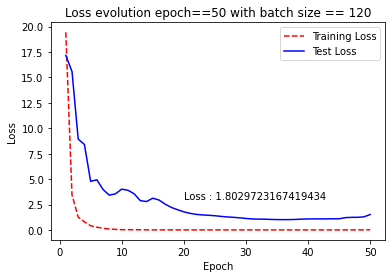

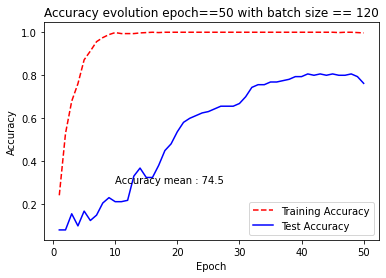

7/7 [==============================] - 0s 20ms/step
Error is :  0.625
Epoch 1/50
6/6 [==============================] - 4s 433ms/step - loss: 22.1217 - accuracy: 0.2516 - val_loss: 36.3203 - val_accuracy: 0.2062
Epoch 2/50
6/6 [==============================] - 1s 154ms/step - loss: 3.4865 - accuracy: 0.5766 - val_loss: 7.7073 - val_accuracy: 0.0500
Epoch 3/50
6/6 [==============================] - 1s 153ms/step - loss: 0.9136 - accuracy: 0.7391 - val_loss: 7.1432 - val_accuracy: 0.1312
Epoch 4/50
6/6 [==============================] - 1s 152ms/step - loss: 0.5997 - accuracy: 0.8297 - val_loss: 5.2273 - val_accuracy: 0.1500
Epoch 5/50
6/6 [==============================] - 1s 153ms/step - loss: 0.3833 - accuracy: 0.8766 - val_loss: 4.7196 - val_accuracy: 0.1562
Epoch 6/50
6/6 [==============================] - 1s 153ms/step - loss: 0.2128 - accuracy: 0.9250 - val_loss: 4.9142 - val_accuracy: 0.1562
Epoch 7/50
6/6 [==============================] - 1s 152ms/step - loss: 0.1264 - accurac

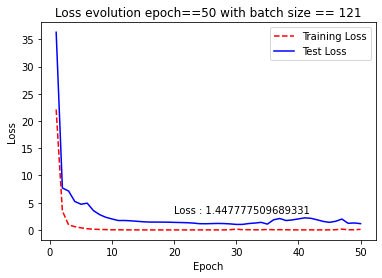

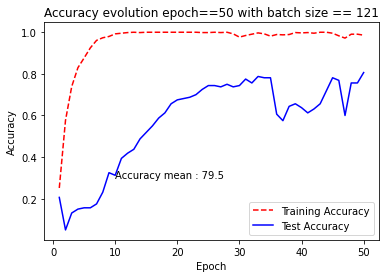

7/7 [==============================] - 0s 21ms/step
Error is :  0.61
Epoch 1/50
6/6 [==============================] - 4s 349ms/step - loss: 15.2973 - accuracy: 0.2891 - val_loss: 64.7655 - val_accuracy: 0.0812
Epoch 2/50
6/6 [==============================] - 1s 157ms/step - loss: 2.4817 - accuracy: 0.5828 - val_loss: 53.2602 - val_accuracy: 0.0812
Epoch 3/50
6/6 [==============================] - 1s 154ms/step - loss: 0.8288 - accuracy: 0.7375 - val_loss: 33.6814 - val_accuracy: 0.0812
Epoch 4/50
6/6 [==============================] - 1s 156ms/step - loss: 0.5657 - accuracy: 0.8234 - val_loss: 17.8223 - val_accuracy: 0.0812
Epoch 5/50
6/6 [==============================] - 1s 157ms/step - loss: 0.3780 - accuracy: 0.8797 - val_loss: 11.7639 - val_accuracy: 0.1000
Epoch 6/50
6/6 [==============================] - 1s 155ms/step - loss: 0.2132 - accuracy: 0.9234 - val_loss: 8.0263 - val_accuracy: 0.1000
Epoch 7/50
6/6 [==============================] - 1s 156ms/step - loss: 0.1183 - accu

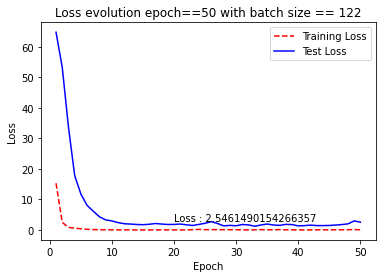

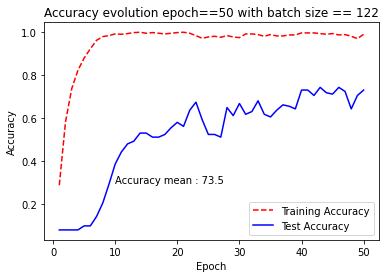

7/7 [==============================] - 0s 14ms/step
Error is :  0.535
Epoch 1/50
6/6 [==============================] - 5s 443ms/step - loss: 13.3847 - accuracy: 0.3000 - val_loss: 42.3906 - val_accuracy: 0.0812
Epoch 2/50
6/6 [==============================] - 1s 151ms/step - loss: 2.6126 - accuracy: 0.6125 - val_loss: 13.8191 - val_accuracy: 0.0812
Epoch 3/50
6/6 [==============================] - 1s 151ms/step - loss: 0.7416 - accuracy: 0.7797 - val_loss: 11.1551 - val_accuracy: 0.0812
Epoch 4/50
6/6 [==============================] - 1s 151ms/step - loss: 0.4581 - accuracy: 0.8594 - val_loss: 10.8718 - val_accuracy: 0.0938
Epoch 5/50
6/6 [==============================] - 1s 150ms/step - loss: 0.2910 - accuracy: 0.9000 - val_loss: 8.2088 - val_accuracy: 0.1187
Epoch 6/50
6/6 [==============================] - 1s 155ms/step - loss: 0.1507 - accuracy: 0.9531 - val_loss: 6.5253 - val_accuracy: 0.1250
Epoch 7/50
6/6 [==============================] - 1s 157ms/step - loss: 0.0824 - accu

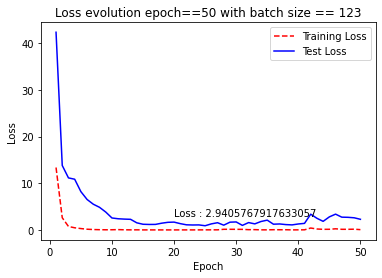

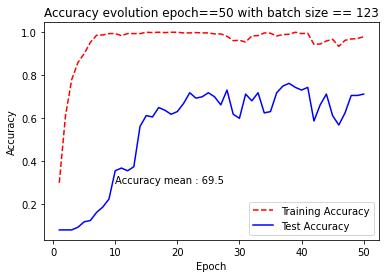

7/7 [==============================] - 0s 20ms/step
Error is :  0.63
Epoch 1/50
6/6 [==============================] - 4s 348ms/step - loss: 13.9684 - accuracy: 0.3234 - val_loss: 27.8424 - val_accuracy: 0.0875
Epoch 2/50
6/6 [==============================] - 1s 170ms/step - loss: 1.9377 - accuracy: 0.6141 - val_loss: 12.3673 - val_accuracy: 0.0812
Epoch 3/50
6/6 [==============================] - 1s 178ms/step - loss: 0.8029 - accuracy: 0.7500 - val_loss: 8.6661 - val_accuracy: 0.0938
Epoch 4/50
6/6 [==============================] - 1s 173ms/step - loss: 0.5419 - accuracy: 0.8234 - val_loss: 7.5763 - val_accuracy: 0.1000
Epoch 5/50
6/6 [==============================] - 1s 165ms/step - loss: 0.2809 - accuracy: 0.9094 - val_loss: 5.2755 - val_accuracy: 0.1187
Epoch 6/50
6/6 [==============================] - 1s 156ms/step - loss: 0.1487 - accuracy: 0.9516 - val_loss: 3.8828 - val_accuracy: 0.1750
Epoch 7/50
6/6 [==============================] - 1s 155ms/step - loss: 0.0677 - accurac

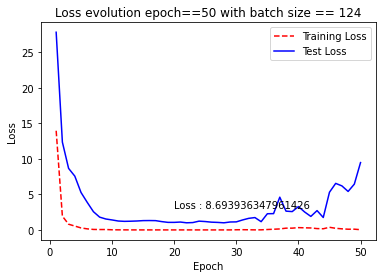

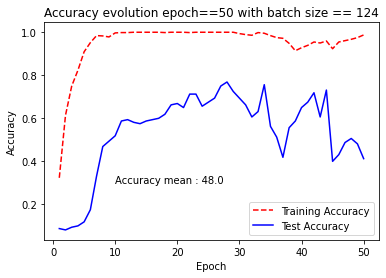

7/7 [==============================] - 0s 19ms/step
Error is :  0.78
Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 13.3104 - accuracy: 0.3281

In [ ]:
#for i in [-1,0,4,6,7,8,10,11,13,15,16,17,18,19,20,22,23,24]:
for i in range(120,140):
  #create the model
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(8, 5, activation='relu', input_shape=(256, 256, 3), padding="same"),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2D(16, 3, activation='relu', padding="same"),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2D(32, 3, activation='relu', padding="same"),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2D(64, 3, activation='relu', padding="same"),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Conv2D(128, 3, activation='relu', padding="same"),
      tf.keras.layers.MaxPooling2D(2),
      tf.keras.layers.BatchNormalization(),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(4096, activation='relu'),
      tf.keras.layers.Dense(4096, activation='relu'),
      tf.keras.layers.Dense(10, activation='sigmoid')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #get the datas
  X_train, X_test, y_train, y_test = apply_policy(-1)

  #train the model
  history = model.fit(X_train, y_train, epochs=50, batch_size=i, validation_split=0.2, verbose=1) 

  #evaluate the testing
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
  print("Value of loss: ", test_loss, " Value of accuracy : ", test_acc)

  #show graphics
  getGraphLoss(history, "Loss evolution epoch==50 with batch size == " + str(i), test_loss)
  getGraphAccuracy(history, "Accuracy evolution epoch==50 with batch size == " + str(i), test_acc)

  # predict and print x_test with y_test
  predModl = model.predict(X_test)
  resultTx = txError(predModl, y_test)
  print("Error is : ", resultTx)

Result Sans batch Norm : 40% d'accuracy

Result avec BN : 68% d'accuracy

Result avec BN et Filtre gaussien : 74%

Result avec 2 layers suplémentaire : 69%

Result avec BN et autoaugment Ciphar 21 SubPolicies : 

Result avec BN et autoaugment ImageNet : 

Result avec BN et autoaugment SVHN : 


Based on this article: https://ieeexplore.ieee.org/abstract/document/7808140

I'll try to use preprocessing techniques before we give the images to the model, as shown in the article ZCA is better than mean normalization and standarization so i'll try to use 4 techniques of normalisation.

In [ ]:
# ======== NORMALIZATION ========

# Compute Low Frequency Subtraction Normalization
def LFSN(image: tf.Tensor) -> tf.Tensor:
    image = tf.cast(image, tf.float32)
    
    # ** 1st - Conversion in greyscale
    image = tf.image.rgb_to_grayscale(image)

    # ** 2nd - Applying low-pass filter and rescale
    image_low = utils.gaussian_filter(image, 16, 7/6)

    # Downsample image
    image_low = utils.rescale(
        image_low,
        1/4,
        method=tf.image.ResizeMethod.BICUBIC)
    # Upsample image
    image_low = tf.image.resize(
            image_low,
            size=utils.image_shape(image),
            method=tf.image.ResizeMethod.BICUBIC)

    # ** 3rd - Return images substerated from their low-pass filtered images
    image_final = image - tf.cast(image_low, image.dtype)
    return image_final
def ZCA_whitening(img):  # WORKS W/ WARNINGS : img_cn.astype(np.uint8)
  normalizer = normalizers.Tools()
  # ** 1st - Apply contrast normalization to the image
  img_cn = normalizer.contrast_normalize(img)
  # ** 2nd - Apply ZCA sphering normalization to the image
  img_normalized = normalizer.ZCA_sphere(img_cn)
  return img_normalized

#Local contrast norm
def LocalContrastNormalization(img, P=3, Q=3, C=1):
    kernel = np.ones((P, Q)) / (P * Q)
    img_mean = convolve2d(img, kernel, boundary='symm', mode='same')
    img_sm = convolve2d(np.square(img), kernel, boundary='symm', mode='same')
    img_std = np.sqrt(np.maximum(img_sm - np.square(img_mean), 0)) + C
    img_ln = (img - img_mean) / img_std
    return img_ln

#Local response normalisation
def LRNColored(img):
  LRN = torch.nn.LocalResponseNorm(3)
  image = img.transpose((2,0,1))
  image_tensor = torch.Tensor(image)
  image_lrn = LRN(image_tensor).numpy().transpose((1,2,0))
  scaled_img = (image_lrn - image_lrn.min())/(image_lrn.max() - image_lrn.min())
  return np.uint8(scaled_img * 255)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)


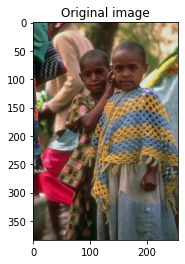

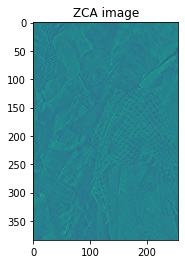

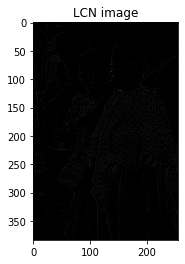

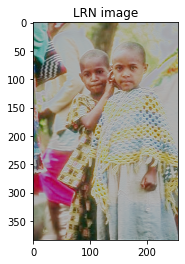

In [ ]:
#Test on wang 0.jpg
img = np.asarray(Image.open('/content/Wang/0.jpg'))
imgUC = Image.open('/content/Wang/0.jpg').convert('L')
imgLFSN = tf.keras.utils.save_img("LFSN.png", LFSN(tf.convert_to_tensor(img)).numpy().squeeze(0))
imgLFSN = Image.open("LFSN.png")
imgZCA = ZCA_whitening(imgUC)
imgLCN =  Image.fromarray(LocalContrastNormalization(imgUC))
imgLRN = LRNColored(img)

#display img
imgplotOriginal = plt.imshow(img)
plt.title("Original image")
plt.show()
imgplotLFSN = plt.imshow(imgLFSN.convert('1'))
plt.title("LFSN image")
plt.show()
imgplotZCA = plt.imshow(imgZCA)
plt.title("ZCA image")
plt.show()
imgplotLCN = plt.imshow(imgLCN)
plt.title("LCN image")
plt.show()
imgplotLCN = plt.imshow(imgLRN)
plt.title("LRN image")
plt.show()

In [ ]:
#preparing dataset of images (resize if necessary)
if os.path.exists('Wang') == False:
  !unzip '/content/drive/MyDrive/Master/ML/Wang.zip' -d '/content/'
imagesPaths = list(paths.list_images("Wang"))
coloredDatas, uncoloredDatas = [], []

target = np.zeros([1000,10], 'int')
ind=0
for imagePath in imagesPaths:
  nom = imagePath.replace('.||', '')
  if os.path.splitext(nom)[1] == '.jpg':
    val = int(int(nom[5:-4])/100)
    target[ind, val]=1
    ind = ind+1
    img = cv2.imread(imagePath)
    coloredDatas.append(img[0:256, 0:256, :])
    ucImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    uncoloredDatas.append(ucImg[0:256, 0:256])

coloredDatas = np.array(coloredDatas, dtype="float")
uncoloredDatas = np.array(uncoloredDatas, dtype="float")

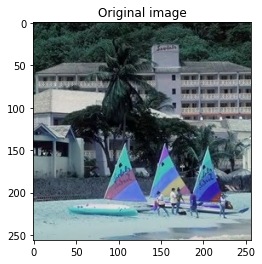

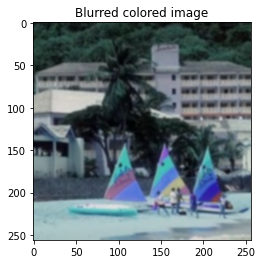

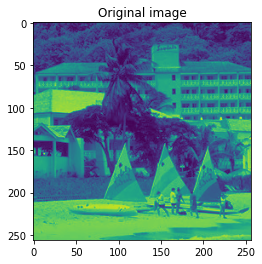

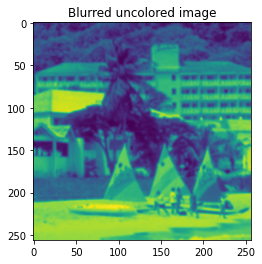

In [ ]:
#Gaussian blur on all the dataset
#display img
imgplotOriginal = plt.imshow(coloredDatas[0].astype('uint8'))
plt.title("Original image")
plt.show()
blur = cv2.GaussianBlur(coloredDatas[0], (5, 5), 0)
imgplotCBlur = plt.imshow(blur.astype('uint8'))
plt.title("Blurred colored image")
plt.show()

imgplotOriginal = plt.imshow(uncoloredDatas[0])
plt.title("Original image")
plt.show()
blur = cv2.GaussianBlur(uncoloredDatas[0], (5, 5), 0)
imgplotUCBlur = plt.imshow(blur)
plt.title("Blurred uncolored image")
plt.show()

for i in range(len(coloredDatas)):
  blur = cv2.GaussianBlur(coloredDatas[i], (3, 3), 0)
  coloredDatas[i] = blur
  blur = cv2.GaussianBlur(uncoloredDatas[i], (3, 3), 0)
  uncoloredDatas[i] = blur

In [ ]:
#preprocessing such as treshold, min_max, LCN, ZCA, LFS
def get_Data_Norm(norm):
  Data, Labels = [], []
  LFSN_Dataset, ZCA_Dataset, LCN_Dataset, Labels = [], [], [], []

  if norm == 'LFSN':
    for i in range(len(coloredDatas)):
      Data.append(LFSN(tf.convert_to_tensor(coloredDatas[i])).numpy())
      Labels.append(target[i])
    Data = np.array(Data).squeeze()
  elif norm == 'LCN':
    for i in range(len(coloredDatas)):
      Data.append(LocalContrastNormalization(uncoloredDatas[i]))
      Labels.append(target[i])
    Data = np.array(Data)
    Data = np.expand_dims(Data, axis=3)
  elif norm == 'ZCA':
    for i in range(len(coloredDatas)):
      Data.append(ZCA_whitening(uncoloredDatas[i]))
      Labels.append(target[i])
    Data = np.array(Data)
    Data = np.expand_dims(Data, axis=3)
  elif norm == 'LRN':
    for i in range(len(coloredDatas)):
      Data.append(LRNColored(coloredDatas[i]))
      Labels.append(target[i])
    Data = np.array(Data)
  Labels = np.array(Labels)
  return Data, Labels

From here i'll try to upgrade the accuracy with a preprocessing techniques the following ones :  SuperVision/AlexNet, GoogLeNet/Inception, VGG, and ResNet.
That were used in the ImageNet Large Scale Visual Recognition Challenge.

Running the model

Epoch 1/30
20/20 [==============================] - 31s 2s/step - loss: 16.2513 - accuracy: 0.2016 - val_loss: 9.6654 - val_accuracy: 0.2188
Epoch 2/30
20/20 [==============================] - 30s 2s/step - loss: 2.1731 - accuracy: 0.5562 - val_loss: 3.9182 - val_accuracy: 0.2937
Epoch 3/30
20/20 [==============================] - 30s 2s/step - loss: 0.4318 - accuracy: 0.8703 - val_loss: 2.8016 - val_accuracy: 0.3500
Epoch 4/30
20/20 [==============================] - 32s 2s/step - loss: 0.1498 - accuracy: 0.9656 - val_loss: 2.2493 - val_accuracy: 0.4125
Epoch 5/30
20/20 [==============================] - 30s 2s/step - loss: 0.0569 - accuracy: 0.9875 - val_loss: 2.0229 - val_accuracy: 0.4563
Epoch 6/30
20/20 [==============================] - 30s 2s/step - loss: 0.0238 - accuracy: 0.9969 - val_loss: 1.7109 - val_accuracy: 0.5500
Epoch 7/30
20/20 [==============================] - 30s 2s/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 1.7104 - val_accuracy: 0.5188
Epoch 8/30
20/20 [=

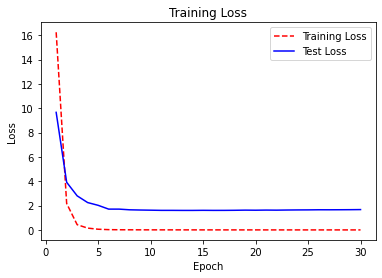

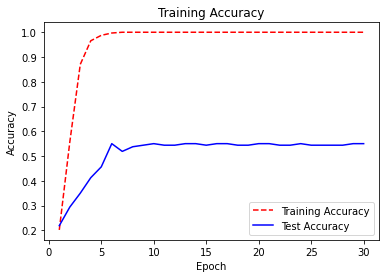

Value of loss:  1.579452395439148  Value of accuracy :  0.5649999976158142


In [ ]:
Data, Labels =  get_Data_Norm('LFSN')

#datas
X_train, X_test, y_train, y_test = train_test_split(Data, Labels, test_size=0.2, random_state=2, stratify=Labels)
batch_size = 32
n_classes = 10
epochs = 20

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, 5, activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='sigmoid')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1) 
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
model.summary()
getGraphLoss(history)
getGraphAccuracy(history)
print("Value of loss: ", test_loss, " Value of accuracy : ", test_acc)

Result avec ZCA : 30% d'accuracy

Result avec LRN : 43% accuracy

Result avec LFSN : 56% accuracy

Result avec LCN : 65% accuracy

In [ ]:
predModl = model.predict(X_test)
resultTx = txError(predModl, y_test)
print("Error is : ", resultTx)
print(predModl.shape)

7/7 [==============================] - 4s 541ms/step
Error is :  1.0
(200, 10)
